# Labeling: Return Over Benchmark


## Abstract

Labeling against benchmark is a simple method of labeling financial data in which time-indexed returns are labeled according to
whether they exceed a set value. The benchmark can be either a constant value, or a pd.Series of values with an index matching
that of the returns. The labels can be the numerical value of how much each observation's return exceeds the benchmark, or the sign of the excess.

## Introduction
The simplest method of labeling is just returning the sign of the return. However, sometimes it is desirable to quantify the return compared to a benchmark to better contextualize the returns. This is commonly done by using the mean or median of multiple stocks in the market. However, that data may not always be available, and sometimes the user might wish a specify a constant or more custom benchmark to compare returns against. 

The paper ["Evaluating multiple classifiers for stock price direction prediction"](https://www.sciencedirect.com/science/article/abs/pii/S0957417415003334) by Ballings et al., (2015) features this labeling method. In this paper, the authors label yearly forward stock returns against a predetermined benchmark, and use that labeled data to compare the performance of several machine learning algorithms in predicting long term price movements.

## How it works

At time $t$, given that price of a stock is $p_{t,n}$, benchmark is $B_t$, and return is:

$$
    r_{t, n} = \frac{p_{t,n}}{p_{t-1,n}} - 1
$$

Note that $B_t$ is a scalar value corresponding to the benchmark at time $t$, while $B$ is the vector of all benchmarks across all timestamps. The labels are:

$$
    L(r_{t, n}) = r_{t, n} - B_t
$$

If categorical labels are desired:

$$
     \begin{equation}
     \begin{split}
       L(r_{t, n}) = \begin{cases}
       -1 &\ \text{if} \ \ r_{t, n} < B_t\\
       0 &\ \text{if} \ \ r_{t, n} = B_t\\
       1 &\ \text{if} \ \ r_{t, n} > B_t\\
       \end{cases}
     \end{split}
     \end{equation}
$$

If desired, the user can specify a [resampling period](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) to apply to the price data prior to calculating returns. The user can also lag the returns to make them forward-looking. In the paper by Ballings et al., the authors use yearly forward returns, and compare them to benchmark values of 15%, 25%, and 35%.


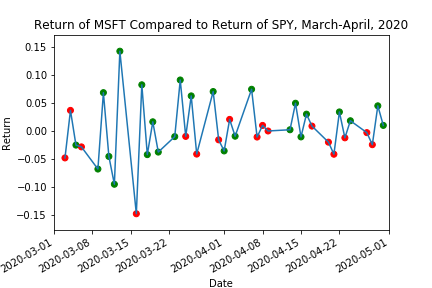

In [1]:
from IPython.display import Image
Image(filename='images/MSFT_Return_vs_Benchmark.png')

_*Fig. 1:*_ Returns of MSFT stock from March-April 2020 compared to returns on SPY. Green dots for when MSFT outperformed SPY, and red for when MSFT underperformed.

---
## Examples of use

In [2]:
# Import packages
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import yfinance as yf

# Import MlFinLab tools
from mlfinlab.labeling.return_vs_benchmark import return_over_benchmark

register_matplotlib_converters()

MLFINLAB_API_KEY is valid.


In [3]:
# Load price data
msft = yf.Ticker('MSFT')
msft_df = msft.history(start='2020-3-1', end ='2020-5-1')
spy = yf.Ticker('SPY')
spy_df = spy.history(start='2020-3-1', end ='2020-5-1')

# Closing prices
msft_price = msft_df['Close']
spy_price = spy_df['Close']

# SPY return for benchmark
spy_returns = spy_price.pct_change(periods=1)
msft_returns = msft_price.pct_change(periods=1)

### Single stock's returns against a benchmark

We can specify a constant benchmark, and return a positive label if the stock returns above 0.5% for the day. 

In [4]:
return1 = return_over_benchmark(prices=msft_price, benchmark=0.005, binary=True, lag=False)
return1.value_counts()

Close
-1.0    24
 1.0    18
Name: count, dtype: int64

We can also use returns on SPY over the same time period as the benchmark. Note that the time indices between the returns and the benchmark must match.

In [5]:
returns2 = return_over_benchmark(prices=msft_price, benchmark=spy_returns, binary=True, lag=False)
returns2.value_counts()

Close
 1.0    25
-1.0    17
Name: count, dtype: int64

We can plot returns on MSFT over time, color coded by whether it exceeds return on SPY for the same day.

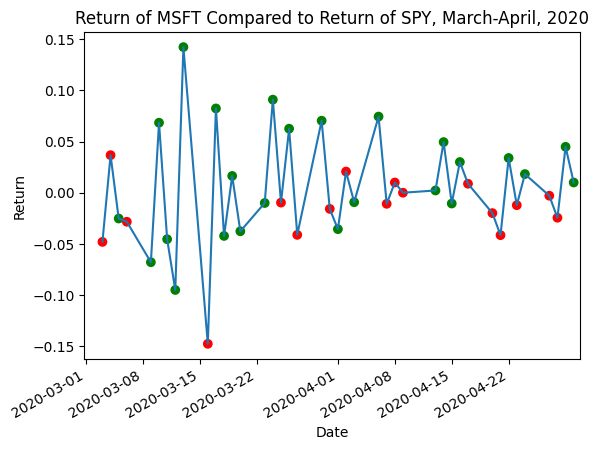

In [6]:
# Set color for points, green for over benchmark, red for below
color = returns2.apply(lambda x: 'g' if x==1 else 'r')

fig, ax = plt.subplots()
ax.scatter(msft_price.index, msft_returns, color=color.to_list())
ax.plot(msft_price.index, msft_returns)
fig.autofmt_xdate()
ax.set_xlim([dt.date(2020, 3, 1), dt.date(2020, 5, 1)])
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.set_title('Return of MSFT Compared to Return of SPY, March-April, 2020');

### Yearly returns over benchmark

In the paper by Ballings et al., the authors use several machine learning techniques to predict one year ahead whether the return will exceed the threshold. They use thresholds of 15%, 25%, and 35%.

In [7]:
tickers = "AAPL MSFT COST PFE SYY F GE BABA AMD CCL ZM WFC JPM NVDA CVX"

data = yf.download(tickers, start="1980-01-01", end="2020-05-01")
data = data['Adj Close']
data.index = pd.to_datetime(data.index)
data.resample('Y').last().head()  

[*********************100%***********************]  15 of 15 completed


,AAPL,AMD,BABA,CCL,COST,CVX,F,GE,JPM,MSFT,NVDA,PFE,SYY,WFC,ZM
Date,,,,,,,,,,,,,,,
1980-12-31,0.118202,5.75000,NaN,NaN,NaN,2.579386,0.170549,2.383898,1.386555,NaN,NaN,0.288462,0.195475,0.283742,NaN
1981-12-31,0.076636,2.93750,NaN,NaN,NaN,2.222937,0.151556,2.351114,1.772838,NaN,NaN,0.297918,0.296487,0.248619,NaN
1982-12-31,0.103481,6.28125,NaN,NaN,NaN,1.659103,0.351746,4.076310,1.976145,NaN,NaN,0.397561,0.587362,0.279779,NaN
1983-12-31,0.084430,16.81250,NaN,NaN,NaN,1.795200,0.581705,5.211590,2.146923,NaN,NaN,0.425038,0.544338,0.403128,NaN
1984-12-31,0.100883,14.75000,NaN,NaN,NaN,1.707306,0.657016,5.228528,2.737634,NaN,NaN,0.521865,0.501315,0.294785,NaN


In [8]:
# Get the labels as a flat array
returns15 = return_over_benchmark(prices=data, benchmark=0.15, binary=True, resample_by='Y', lag=True).values.flatten()
returns25 = return_over_benchmark(prices=data, benchmark=0.25, binary=True, resample_by='Y', lag=True).values.flatten()
returns35 = return_over_benchmark(prices=data, benchmark=0.35, binary=True, resample_by='Y', lag=True).values.flatten()

# Get the count of positive returns, ignoring NaN
_, count15 = np.unique(returns15[~np.isnan(returns15)], return_counts=True)  # Given as [count of -1, count of 1]
_, count25 = np.unique(returns25[~np.isnan(returns25)], return_counts=True)
_, count35 = np.unique(returns35[~np.isnan(returns35)], return_counts=True)

# Get the ratio of positive labels to all labels
ratio15 = count15[1]/count15.sum()
ratio25 = count25[1]/count25.sum()
ratio35 = count35[1]/count35.sum()
ratio15, ratio25, ratio35

(0.49284253578732107, 0.3721881390593047, 0.26993865030674846)

We can visualize the probability of positive returns based on the benchmarks used by Ballings et al. Obviously, higher benchmarks result in fewer positive labels. 

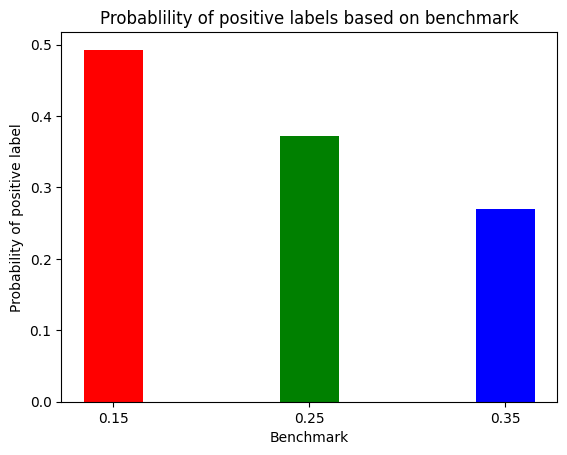

In [9]:
ax = plt.bar(['0.15', '0.25', '0.35'], [ratio15, ratio25, ratio35], width=0.3, color=['r', 'g', 'b'])
plt.xlabel('Benchmark')
plt.ylabel('Probability of positive label')
plt.title('Probablility of positive labels based on benchmark');

### Error Handling

An exception will be raised if the index of benchmark (if benchmark is a pd.Series) does not match with the index of the returns. As previously noted, in order for the function to correctly subtract the benchmark from the returns, they must have the same time index. 

In [10]:
# Suppose we apply a resample period to price, but forget to do so for returns
return_over_benchmark(msft_price, spy_price, resample_by='W').head()

AssertionError: Index of returns and benchmark do not match. If resampling is used, index of benchmark must match index of resampled data.

---
## Conclusion

This notebook presents the method to label data according to return over a given benchmark. This method can return either numerical or categorical labels for observations. In this process, returns are first calculated from prices, with resampling if necessary. The returns are compared to a benchmark of returns. The benchmark is subtracted from the stock returns to determine the excess return over benchmark. The labels can be returned numerically or can be relabeled to represent their signs. This approach potentially gives the user more flexibility than labeling according to the mean or median at each time index. When making trading decisions, there may be an opportunity cost. Setting the benchmark equal to something like interest rate or market return would inform whether a trade is profitable compared to investing the assets elsewhere.

## References

1. Ballings, M., Van den Poel, D., Hespeels, N. and Gryp, R., 2015. Evaluating multiple classifiers for stock price direction prediction. Expert Systems with Applications, 42(20), pp.7046-7056.
2. Coqueret, G. and Guida, T., 2020. Machine Learning For Factor Investing.